In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

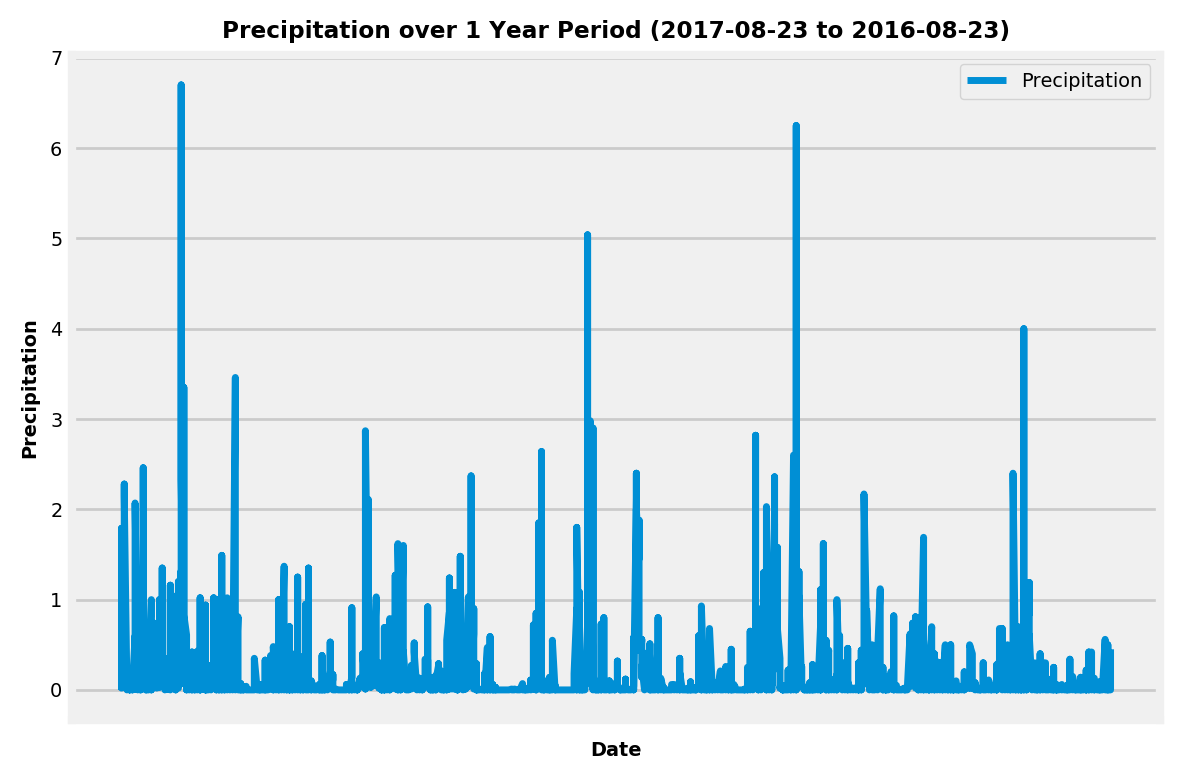

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
end_date = dt.datetime.strptime(latest_date, '%Y-%m-%d').date()
start_date = dt.datetime.strftime(end_date - dt.timedelta(days=365),'%Y-%m-%d')
start_date


# Perform a query to retrieve the data and precipitation scores
rain_data = session.query(Measurement.date, Measurement.prcp)\
            .filter(func.strftime('%Y-%m-%d', Measurement.date) >= start_date).all()


# Save the query results as a Pandas DataFrame and set the index to the date column
rain_df = pd.DataFrame(rain_data)
rain_df = rain_df.set_index('date')


# Sort the dataframe by date
rain_df = rain_df.sort_values(by='date')
rain_df = rain_df.dropna()
rain_df


# Use Pandas Plotting with Matplotlib to plot the data
plt.rcParams['figure.dpi'] = 200
fig, rain = plt.subplots()

rain.plot(rain_df.index, rain_df['prcp'], linewidth=2.5, label='Precipitation', zorder=2)

plt.legend(fontsize='x-small', loc='best')
plt.title(f'Precipitation over 1 Year Period ({latest_date} to {start_date})', fontsize='small', weight='bold')
plt.xlabel('Date', fontsize='x-small', weight='bold')
plt.ylabel('Precipitation', fontsize='x-small', weight='bold')
plt.yticks(fontsize='x-small')
rain.set_xticklabels([])
rain.xaxis.grid(False, which='both')

plt.tight_layout()
plt.savefig('Output/Precipitation.png')

plt.show()

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
# rain_summary = rain_df['prcp'].agg('describe')[['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']]
rain_summary = rain_df.agg('describe')[{'prcp':['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']}]
rain_summary = rain_summary.rename(columns={'prcp':'precipitation'})
rain_summary

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [12]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Measurement.station).distinct().count()
station_count

9

In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stn_activity = session.query(Measurement.station, func.count(Measurement.station))\
               .group_by(Measurement.station)\
               .order_by(func.count(Measurement.station)\
               .desc())\
               .all()
stn_activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
stn_most_active = stn_activity[0][0]
stn_most_active

sel = [func.min(Measurement.tobs),
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs)]

stn_summary = session.query(*sel).filter(Measurement.station == stn_most_active).all()
stn_summary

[(54.0, 85.0, 71.66378066378067)]

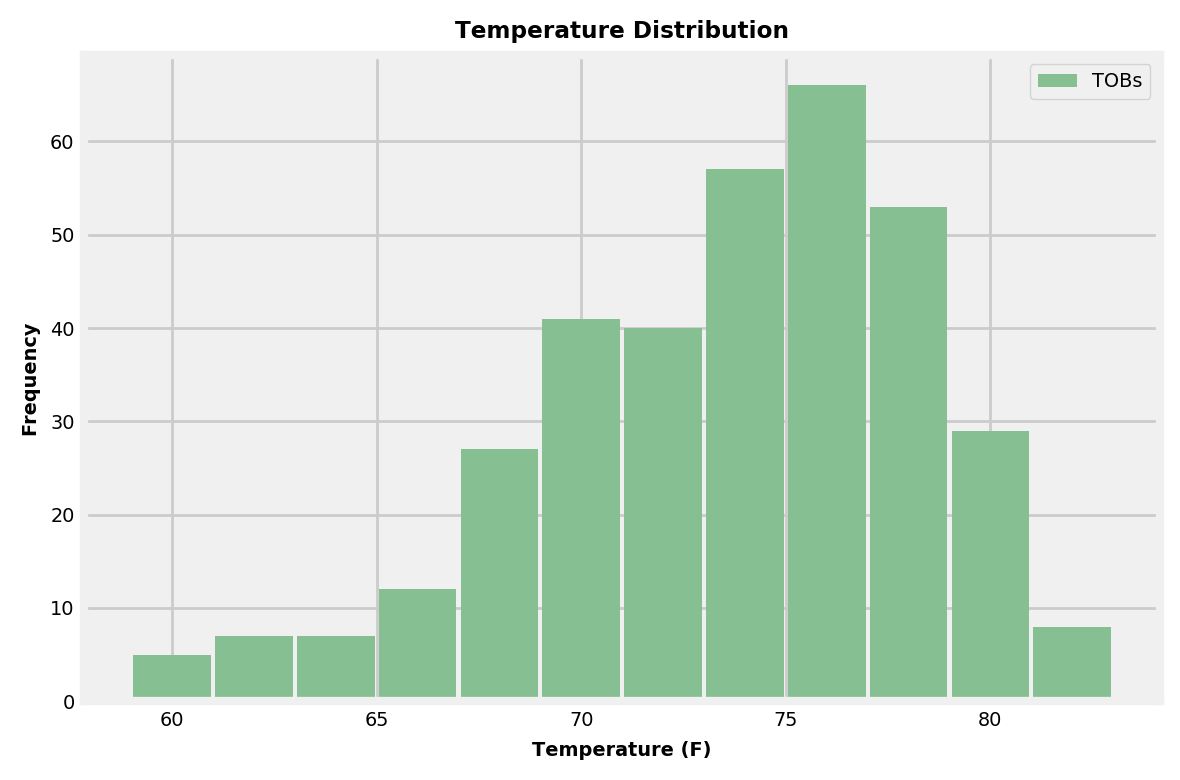

In [15]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_data = session.query(Measurement.tobs).\
            filter(Measurement.station == stn_most_active).\
            filter(func.strftime('%Y-%m-%d', Measurement.date) >= start_date).all()

temp_df = pd.DataFrame(temp_data)

plt.rcParams['figure.dpi'] = 200
fig, temp = plt.subplots()

temp.hist(temp_df['tobs'], bins=12, color='#86bf91', rwidth=0.95, label='TOBs', zorder=2)

plt.legend(fontsize='x-small', loc='best')
plt.title(f'Temperature Distribution', fontsize='small', weight='bold')
plt.xlabel('Temperature (F)', fontsize='x-small', weight='bold')
plt.ylabel('Frequency', fontsize='x-small', weight='bold')
plt.xticks(fontsize='x-small')
plt.yticks(fontsize='x-small')


plt.tight_layout()
plt.savefig('Output/Temperature.png')

plt.show()

In [16]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
# print(calc_temps('2012-02-28', '2012-03-05'))

In [27]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
vacation_start = '2017-03-15'
vacation_end = '2017-03-29'

results = calc_temps(vacation_start, vacation_end)

t_min = results[0][0]
t_ave = results[0][1]
t_max = results[0][2]

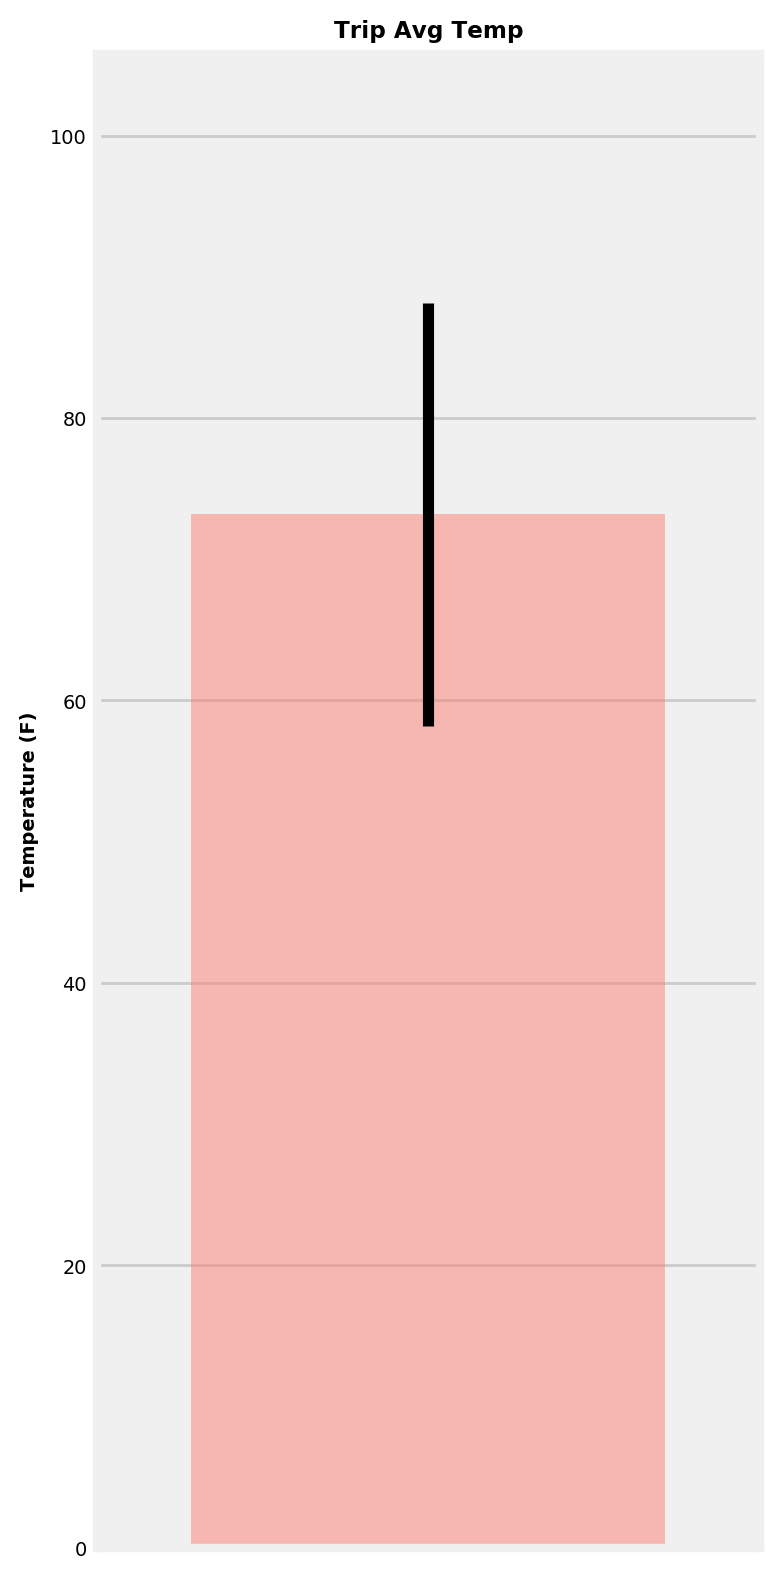

In [18]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

fig, vacation = plt.subplots(figsize=plt.figaspect(2.))

vacation.bar(1, t_ave, yerr=t_max-t_min, color='salmon', alpha=.5)

plt.title('Trip Avg Temp', fontsize='small', weight='bold')
plt.ylabel('Temperature (F)', fontsize='x-small', weight='bold')
plt.xticks(fontsize='x-small')
plt.yticks(fontsize='x-small')
vacation.set_xticklabels([])
vacation.xaxis.grid(False, which='both')
vacation.margins(.2, .2)

plt.tight_layout()
plt.savefig('Output/Vacation_Temperature.png')

plt.show()

In [28]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
# 2017-03-15 to 2017-03-29

sel = [func.sum(Measurement.prcp), 
       Measurement.station, 
       Station.name, 
       Station.latitude, 
       Station.longitude, 
       Station.elevation]

vacation_rain = session.query(*sel)\
                .filter(Measurement.station == Station.station)\
                .filter(func.strftime('%Y-%m-%d', Measurement.date) >= vacation_start)\
                .filter(func.strftime('%Y-%m-%d', Measurement.date) <= vacation_end)\
                .group_by(Station.station)\
                .order_by(func.sum(Measurement.prcp).desc())\
                .all()

vacation_df = pd.DataFrame(vacation_rain, columns=['total prcp','station','name','latitude','longitude', 'elevation'])
vacation_df

,total prcp,station,name,latitude,longitude,elevation
0,1.43,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
1,1.36,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
2,0.95,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
3,0.95,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
4,0.24,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
5,0.02,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
6,0.00,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [23]:
# Plot the daily normals as an area plot with `stacked=False`
